In [236]:
import json
import os
from shapely import Polygon, MultiPolygon
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
from collections import deque

In [237]:
def bfs_split_mask(mask):
    rows, cols, *_ = mask.shape
    binary_mask = np.zeros((rows, cols))
    binary_mask[mask[:, :, 3] > 0] = 1
    visited = np.zeros_like(binary_mask, dtype=bool)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    regions = []

    for r in range(rows):
        for c in range(cols):
            if binary_mask[r, c] == 1 and not visited[r, c]:
                region = np.zeros_like(binary_mask, dtype=np.uint8)
                queue = deque([(r, c)])
                visited[r, c] = True

                while queue:
                    x, y = queue.popleft()
                    region[x, y] = 1

                    for dx, dy in directions:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < rows and 0 <= ny < cols and binary_mask[nx, ny] == 1 and not visited[nx, ny]:
                            queue.append((nx, ny))
                            visited[nx, ny] = True

                regions.append(region)

    return regions

def regions_to_polygons(regions):
    polygons = []
    for region in regions:
        contours, _ = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            coords = [(point[0][0], point[0][1]) for point in contour]

            if len(coords) < 3:
                continue

            polygon = Polygon(coords)

            if polygon.is_valid and polygon.area > 0:
                polygons.append(polygon)
            elif polygon.buffer(0).is_valid:
                polygon = polygon.buffer(0)
                if isinstance(polygon, MultiPolygon):
                    for polygon_split in list(polygon.geoms):
                        polygons.append(polygon_split)
                else:
                    polygons.append(polygon.buffer(0))

    return polygons

def transform_point(point, H):
    point = np.array([*point, 1])
    transformed_point = np.dot(H, point)
    transformed_point /= transformed_point[2]
    return transformed_point[:2]

def transform_polygon(polygon, H, scale=1):
    transformed_points = [transform_point(p, H) * scale for p in np.array(polygon.exterior.coords)]
    return Polygon(transformed_points)

def filter_polygons(polygons: list[Polygon], min_size=5):
    return [p for p in polygons if p.area > min_size]

### Loading polygons

In [238]:
with open("parking_area2.json", 'r') as poly_file:
    polygons_data = json.load(poly_file)

parking_polygons = [Polygon(xy) for xy in polygons_data.values()]

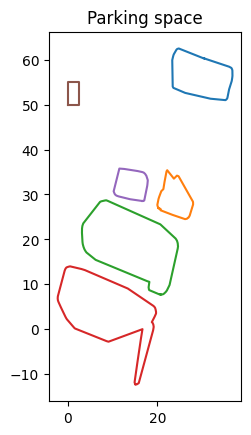

In [239]:
for poly in parking_polygons:
    plt.plot(*poly.exterior.xy)

example_parking_slot = Polygon([[0, 50], [2.5, 50], [2.5, 55], [0, 55]])
plt.plot(*example_parking_slot.exterior.xy)

plt.title("Parking space")
plt.axis('scaled')
plt.show()

### Detecting occupancy

In [240]:
info_path = r'C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\homography_info'
with open(os.path.join(info_path, 'info.json'), 'r') as info_file:
    homography_info = json.load(info_file)

H1 = np.load(os.path.join(info_path, homography_info['cameras']['weti1']['filename']))
H2 = np.load(os.path.join(info_path, homography_info['cameras']['weti2']['filename']))
H12 = np.load(os.path.join(info_path, homography_info['cameras']['weti1_weti2']['filename']))

homography = {
    'weti1': H1,
    'weti2': H2,
    'weti1_weti2': H12
}

In [241]:
occupancy_path = r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\segmentation\occupancy"
weti1_paths = [
    r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\segmentation\occupancy\weti1_2024_11_13_09_17_allowed.png",
    r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\segmentation\occupancy\weti1_2024_11_13_12_20_allowed.png",
]
weti2_paths = [
    r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\segmentation\occupancy\weti2_2024_11_13_09_17_allowed.png",
    r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\segmentation\occupancy\weti2_2024_11_13_12_20_allowed.png",
]
offx1, offy1 = homography_info['cameras']['weti1']['offset']
offx2, offy2 = homography_info['cameras']['weti2']['offset']
occ_weti1 = [cv2.imread(p, cv2.IMREAD_UNCHANGED)[offy1:, offx1:] for p in weti1_paths]
occ_weti2 = [cv2.imread(p, cv2.IMREAD_UNCHANGED)[offy2:, offx2:] for p in weti2_paths]

occ_weti1 = [regions_to_polygons(bfs_split_mask(o1)) for o1 in occ_weti1]
occ_weti2 = [regions_to_polygons(bfs_split_mask(o2)) for o2 in occ_weti2]

occ_weti1 = [[transform_polygon(poly, homography['weti1']) for poly in poly_list] for poly_list in occ_weti1]
occ_weti1 = [[transform_polygon(poly, homography['weti1_weti2']) for poly in poly_list] for poly_list in occ_weti1]
occ_weti2 = [[transform_polygon(poly, homography['weti2']) for poly in poly_list] for poly_list in occ_weti2]

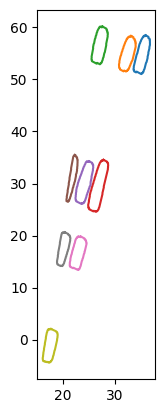

In [242]:
for o1 in occ_weti1[0]:
    plt.plot(*o1.exterior.xy)

plt.axis('scaled')
plt.show()

### Subtracting occupied area

In [243]:
def sub_polygons(base_polygon, sub_polygons):
    diff = base_polygon
    for sub_poly in sub_polygons:
        diff = diff.difference(sub_poly)
    return diff

def fix_multipolygons(polygons_list):
    polygons_list_fixed = []
    for poly in polygons_list:
        print(f"{poly=}")
        if isinstance(poly, MultiPolygon):
            for p in poly.geoms:
                polygons_list_fixed.append(p)
        else:
            polygons_list_fixed.append(poly)
    return polygons_list_fixed

def plot_poly(poly, c='green'):
    if isinstance(poly, MultiPolygon):
        for p in poly.geoms:
            plt.plot(*p.exterior.xy, color=c)
            for inner in p.interiors:
                xi, yi = zip(*inner.coords[:])
                plt.plot(xi, yi, color="black")
    else:
        plt.plot(*poly.exterior.xy, color=c)
        for inner in poly.interiors:
            xi, yi = zip(*inner.coords[:])
            plt.plot(xi, yi, color="black")

def filter_polygons(polygons, min_size=5*2.5*0.8):
    polygons_filtered = []
    for poly in polygons:
        if poly.area >= min_size:
            polygons_filtered.append(poly)
    return polygons_filtered

In [244]:
# parking_polygons[3]
for p in occ_weti1[1]:
    print(min(p.exterior.xy[1]))

min(occ_weti1[1][-1].exterior.xy[1])

24.622142096287305
26.213059191972665
26.5863492757597
7.824719842557526
10.71839294623531
-12.062973638599276


-12.062973638599276

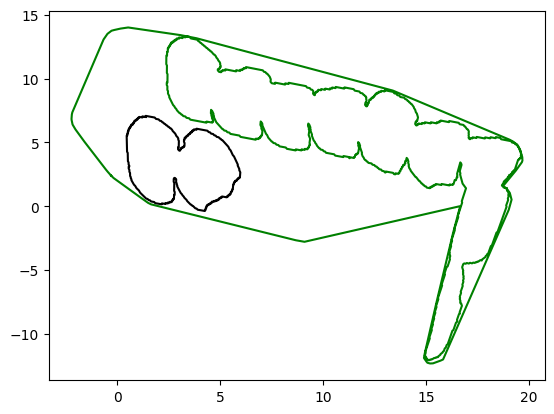

In [245]:
from descartes import PolygonPatch
pp = parking_polygons[3]
op = occ_weti1[0][-1]

pp = pp.difference(op)
for o in occ_weti1[1] + occ_weti2[1]:
    pp = pp - o
plot_poly(pp)

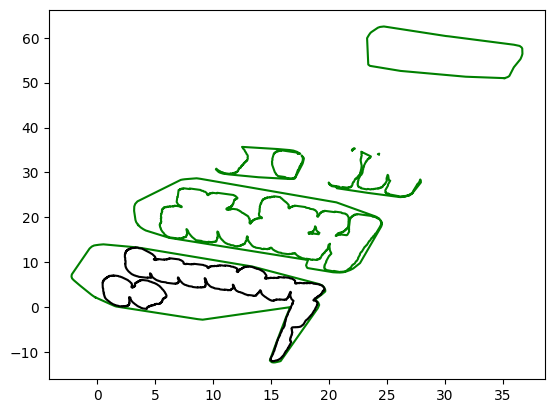

In [246]:
pps = [poly for poly in parking_polygons]
pps_sub = []
for pp in pps:
    for o in occ_weti1[1] + occ_weti2[1]:
        pp = pp - o
    pps_sub.append(pp)
    plot_poly(pp)

# for parking_poly in pps_sub:
#     if isinstance(parking_poly, MultiPolygon):
#         for p in parking_poly.geoms:
#             plt.plot(*p.exterior.xy)
#     elif isinstance(parking_poly, Polygon):
#         plt.plot(*parking_poly.exterior.xy)

# plt.axis('scaled')
# plt.show()

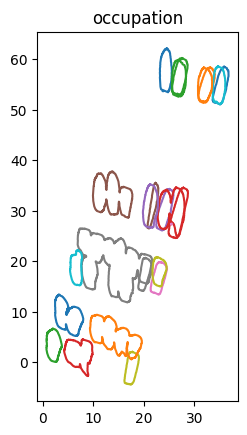

polies=<POLYGON ((20.639 23.346, 24.032 20.192, 24.146 20.024, 24.339 19.702, 24.47...>
polies=<POLYGON ((20.639 23.346, 24.032 20.192, 24.146 20.024, 24.339 19.702, 24.47...>
polies=<POLYGON ((20.639 23.346, 24.032 20.192, 24.146 20.024, 24.339 19.702, 24.47...>
polies=<POLYGON ((20.639 23.346, 24.032 20.192, 24.146 20.024, 24.339 19.702, 24.47...>
polies=<POLYGON ((20.639 23.346, 24.032 20.192, 24.146 20.024, 24.339 19.702, 24.47...>


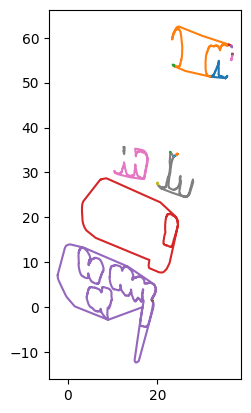

In [247]:
timestamp = 0
occupancies = occ_weti1[timestamp] + occ_weti2[timestamp]

for o in occupancies:
    plt.plot(*o.exterior.xy)
plt.axis('scaled')
plt.title("occupation")
plt.show()

parking_polygons_sub_v2 = [sub_polygons(parking_poly, occupancies) for parking_poly in parking_polygons]
for parking_poly in parking_polygons:
    poly = sub_polygons(parking_poly, occupancies)
    print(f"{polies=}")
    if isinstance(poly, MultiPolygon):
        for p in poly.geoms:
            plt.plot(*p.exterior.xy)
    elif isinstance(poly, Polygon):
        plt.plot(*poly.exterior.xy)

plt.axis('scaled')
plt.show()

poly=<MULTIPOLYGON (((33.999 57.626, 33.948 57.404, 33.944 57.212, 33.919 57.225,...>
poly=<MULTIPOLYGON (((22.885 30.132, 22.751 29.421, 22.752 29.418, 22.72 29.369, ...>
poly=<POLYGON ((7.573 28.501, 8.295 28.666, 8.576 28.707, 8.886 28.597, 20.639 23...>
poly=<MULTIPOLYGON (((-2.205 7.186, -2.181 7.354, -0.664 13.06, -0.473 13.501, -0...>
poly=<MULTIPOLYGON (((12.49 34.449, 12.504 34.602, 12.477 34.771, 12.506 35.079, ...>


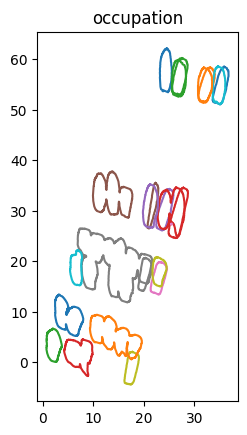

38.67533919935093 0.4186074016180635
2.6227731714295768 0.34781235703463564
1.2614016089061632e-15 0.9988303852016422
0.01944381564925295 1.0
0.006293919121162654 1.0
0.036228675131564025 1.0
0.04171721093360541 0.9999999999999999
7.88628916736859 0.1761270043465862
0.0005958801190595264 1.0
0.008204059449210786 0.7495442789413219
6.373988906224924e-06 1.0
0.000921179331275941 1.0
0.03631961759675488 0.6902806720351651
122.44405978940985 0.4343365108216617
126.69456022883664 0.3897869028600477
0.0057457321325374835 1.0
0.24635530135895542 0.8523611285052326
6.36085230725312 0.19625996057344927


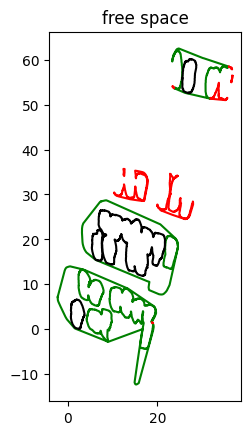

38.67533919935093
122.44405978940985
126.69456022883664
3 18
total free space area: 287.8139592175974m^2, ~23.025116737407792 spaces


In [270]:
timestamp = 0
parking_polygons_sub = fix_multipolygons([sub_polygons(parking_poly, occ_weti2[timestamp] + occ_weti1[timestamp]) for parking_poly in parking_polygons])

for o in occ_weti1[timestamp] + occ_weti2[timestamp]:
    plt.plot(*o.exterior.xy)
plt.axis('scaled')
plt.title("occupation")
plt.show()

for poly in parking_polygons_sub:
    print(poly.area, poly.area / poly.convex_hull.area)
    if poly.area > 5 * 2.5 * 0.8: #and poly.area / poly.convex_hull.area > 0.5:
        plot_poly(poly)
    else:
        plot_poly(poly, 'red')

plt.axis('scaled')
plt.title("free space")
plt.show()

parking_polygons_sub_filtered = filter_polygons(parking_polygons_sub, 5 * 2.5 * 0.8)
total_free_space = sum([poly.area for poly in parking_polygons_sub_filtered])
for poly in parking_polygons_sub_filtered:
    print(poly.area)
print(len(parking_polygons_sub_filtered), len(parking_polygons_sub))
print(f"total free space area: {total_free_space}m^2, ~{total_free_space / (5*2.5)} spaces")

### Grid approach

In [258]:
from shapely import Point

In [271]:
right = max([max(poly.exterior.xy[0]) for poly in parking_polygons_sub_filtered])
left = min([min(poly.exterior.xy[0]) for poly in parking_polygons_sub_filtered])
top = max([max(poly.exterior.xy[1]) for poly in parking_polygons_sub_filtered])
bottom = min([min(poly.exterior.xy[1]) for poly in parking_polygons_sub_filtered])
width = right - left
height = top - bottom
print(f"top left {(top, left)}, bottom right {(bottom, right)}, {width=}, {height=}")

parking_multipolygon = MultiPolygon(parking_polygons_sub_filtered)

top left (62.51518079806133, -2.2203387350867514), bottom right (-12.309529214234619, 35.895768791808656), width=38.116107526895405, height=74.82471001229595


In [297]:
tile_size = 0.5
width_range = np.arange(left - tile_size, right + tile_size, tile_size)
height_range = np.arange(bottom - tile_size, top + tile_size, tile_size)

width_num = len(width_range) - 1
height_num = len(height_range) - 1

parking_grid = np.zeros((width_num, height_num))

for x in range(width_num):
    for y in range(height_num):
        l, r = width_range[x:x+2]
        b, t = height_range[y:y+2]
        poly = Polygon([[l, t], [r, t], [r, b], [l, b]])
        # point = Point([(l+r)/2, (b+t)/2])
        # aaa = parking_multipolygon.contains(point)
        parking_grid[x, y] = parking_multipolygon.intersection(poly).area / poly.area
        # print(f"{parking_grid[x, y]=}")

In [312]:
def filter_by_adjacency(array2d):
    padded_array = np.pad(array2d, pad_width=1, mode='constant', constant_values=0)
    
    # Get neighbor counts using slicing
    neighbors_count = (
        padded_array[:-2, 1:-1] +  # Top
        padded_array[2:, 1:-1] +  # Bottom
        padded_array[1:-1, :-2] + # Left
        padded_array[1:-1, 2:]    # Right
    )
    filtered_array = ((array2d == 1) & (neighbors_count >= 2)).astype(int)
    
    return filtered_array

def filter_by_masks(array2d, mask_size=3):
    padded_array = np.pad(array2d, pad_width=1, mode='edge')
    width, height = array2d.shape
    for x in range(width-mask_size+1):
        for y in range(height-mask_size+1):
            # print(np.sum(array2d[x:x+mask_size, y:y+mask_size]))
            if np.sum(array2d[x:x+mask_size, y:y+mask_size]) / mask_size ** 2 < 0.5:
                padded_array[x + mask_size//2, y + mask_size//2] = 0
    return padded_array[1:-1, 1:-1]

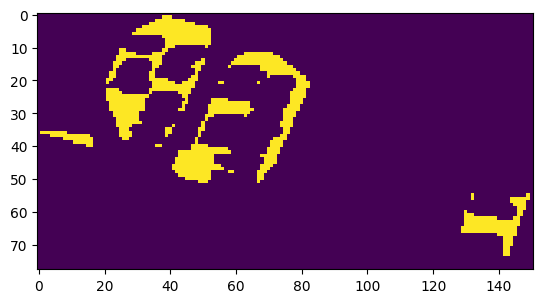

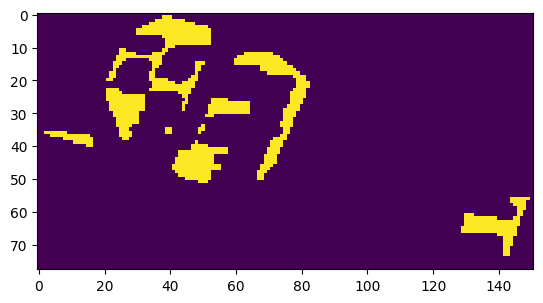

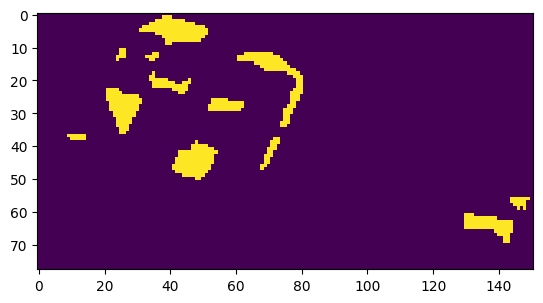

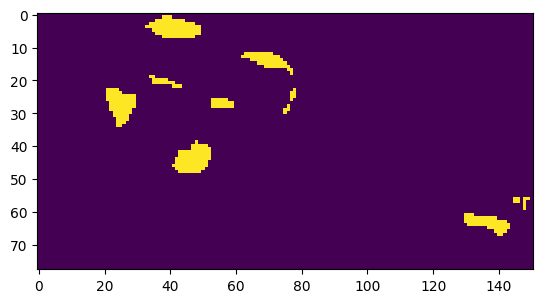

In [317]:
# parking_grid.max()
parking_grid_t = parking_grid.copy()
parking_grid_t[parking_grid_t < 0.75] = 0
parking_grid_t[parking_grid_t >= 0.75] = 1
plt.imshow(parking_grid_t)
plt.show()

parking_grid_t_filtered = filter_by_adjacency(parking_grid_t)
plt.imshow(parking_grid_t_filtered)
plt.show()

parking_grid_t_filtered_mask = filter_by_masks(parking_grid_t_filtered, 5)
plt.imshow(parking_grid_t_filtered_mask)
plt.show()
parking_grid_t_filtered_mask = filter_by_masks(parking_grid_t_filtered_mask, 5)
plt.imshow(parking_grid_t_filtered_mask)
plt.show()

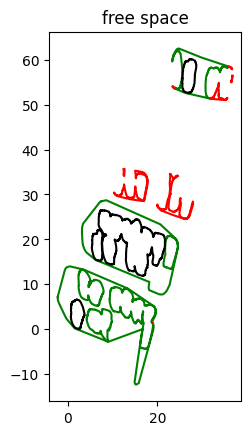